Derive and validate the functionality of the boundary sampler from GINN repo to make sure it works properly

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

google_drive_path = '' 
os.chdir(google_drive_path)
print("Current working directory:", os.getcwd())
!ls
!python -m pip install cripser==0.0.15

Mounted at /content/gdrive
Current working directory: /content/gdrive/Othercomputers/My Mac/Code
 Dataset_generation		    requirements.txt
 File_Paths			    results_distributed2d
 Functions			    results_distributed2d_0.7
'Function Validation and testing'   results_distributed2d_keep_edges_soft
 hard_GINN_results		    results_distributed2d_mdke
 JEB_topo_0.3			    SimJEB_Data
 JEB_topo_0.6			    Test_Cases
 Litterature_Review		    Trained_Models
 Loss_functions			    Trained_Models_final
 Models				    Training_Functions
 Model_Training_Scripts		    Training_Log
 Optimizers


In [ ]:

import os
import sys
# To allow me to import the functiosn from other folders from the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
import numpy as np
import matplotlib.pyplot as  plt
from pathlib import Path
from torchsummary import summary
import time
import torch.nn as nn
from scipy.interpolate import griddata
from tqdm import trange
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader,TensorDataset
from tabulate import tabulate

from Functions.Point_Sampling.point_sampler import Point_Sampler
from Test_Cases.Bridge_around_object.BRIDGE_Master_object import BRIDGE_Master_Object

BRIDGE = BRIDGE_Master_Object(Normalize=True,Symmetry=False)
BRIDGE.create_interfaces() 

from File_Paths.file_paths import interfaces_path, mesh_path
from Functions.Point_Sampling.point_sampler import Point_Sampler

import os
import math
import random
from dataclasses import dataclass, field
from typing import Tuple, List, Optional
from typing import Optional, Tuple, Callable,Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from Models.GINN_Models.GINN import GINN
import cripser as cr

from Functions.Plotting_functions.GINN_output_logging import plot_GINN_geometry

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
GINN_hparams = {
'smooth_enable': True,
'smooth_surface_points': 4000,
'smooth_interface_pts': 2048,
'smooth_interface_cutoff': 0.0,      
'smooth_level_set': 0.0,
'smooth_equidistant_init_grid': True,
'smooth_uniformize': True,
'smooth_inflate_bounds': 0.05,
}

In [ ]:
import math
import torch
import torch.nn.functional as F

class ShapeBoundaryHelperSingle:
    """
    Boundary sampler for a *single* shape (no z).
    derived from "https://github.com/ml-jku/GINNs-Geometry-informed-Neural-Networks/tree/main ".
    """
    def __init__(
        self,
        *,
        dim: int,                         
        bounds,                           
        model: torch.nn.Module,           
        x_interface: torch.Tensor,        
        n_points_surface: int,
        equidistant_init_grid: bool = True,
        interface_cutoff: float = 0.0,
        level_set: float = 0.0,
        do_uniform_resampling: bool = True,
        surf_pts_lr: float = 0.01,
        surf_pts_n_iter: int = 10,
        surf_pts_prec_eps: float = 1.0e-3,
        surf_pts_converged_interval: int = 1,
        surf_pts_use_newton: bool = True,
        surf_pts_newton_clip: float = 0.15,
        surf_pts_inflate_bounds_amount: float = 0.05,
        surf_pts_uniform_n_iter: int = 10,
        surf_pts_uniform_nof_neighbours: int = 16,
        surf_pts_uniform_stepsize: float = 0.75,
        surf_pts_uniform_n_iter_reproj: int = 5,
        surf_pts_uniform_prec_eps: float = 1.0e-3,
        surf_pts_uniform_min_count: int = 1000,
    ):

        self.nx = int(dim)
        try:
            self.device = next(model.parameters()).device
        except StopIteration:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dtype = torch.float32

        #  accept flat BRIDGE.domain and reshape to [nx,2] on model device 
        b = torch.as_tensor(bounds, dtype=self.dtype, device=self.device).flatten()
        if b.numel() != 2 * self.nx:
            raise ValueError(f"bounds must have {2*self.nx} values (flat [xmin,xmax,...]), got {b.numel()}")
        self.bounds = torch.stack([b[2*i:2*i+2] for i in range(self.nx)], dim=0)  # [nx,2]

        self.model = model
        if x_interface is not None and x_interface.numel() > 0:
            self.x_interface = x_interface.to(self.device, dtype=self.dtype)
        else:
            self.x_interface = torch.empty(0, self.nx, device=self.device, dtype=self.dtype)

        # config 
        self.interface_cutoff = float(interface_cutoff)
        self.level_set = float(level_set)

        self.surf_pts_nof_points = int(n_points_surface)
        self.equidistant_init_grid = bool(equidistant_init_grid)
        self.surf_pts_do_uniform_resampling = bool(do_uniform_resampling)

        self.surf_pts_lr = float(surf_pts_lr)
        self.surf_pts_n_iter = int(surf_pts_n_iter)
        self.surf_pts_prec_eps = float(surf_pts_prec_eps)
        self.surf_pts_converged_interval = int(surf_pts_converged_interval)
        self.surf_pts_use_newton = bool(surf_pts_use_newton)
        self.surf_pts_newton_clip = float(surf_pts_newton_clip)

        self.surf_pts_uniform_n_iter = int(surf_pts_uniform_n_iter)
        self.surf_pts_uniform_nof_neighbours = int(surf_pts_uniform_nof_neighbours)
        self.surf_pts_uniform_stepsize = float(surf_pts_uniform_stepsize)
        self.surf_pts_uniform_n_iter_reproj = int(surf_pts_uniform_n_iter_reproj)
        self.surf_pts_uniform_prec_eps = float(surf_pts_uniform_prec_eps)
        self.surf_pts_uniform_min_count = int(surf_pts_uniform_min_count)
        self.knn_k = self.surf_pts_uniform_nof_neighbours

        self._inflate_bounds(surf_pts_inflate_bounds_amount)
        self._precompute_sample_grid()

    # ---------- setup ----------
    def _inflate_bounds(self, amount: float = 0.10) -> None:
        lengths = self.bounds[:, 1] - self.bounds[:, 0]
        self.bounds[:, 0] -= lengths * amount
        self.bounds[:, 1] += lengths * amount

    @staticmethod
    def _get_is_out_mask(x: torch.Tensor, bounds: torch.Tensor) -> torch.Tensor:
        return (x < bounds[:, 0]).any(1) | (x > bounds[:, 1]).any(1)

    def _precompute_sample_grid(self) -> None:
        n_points = self.surf_pts_nof_points
        bounds   = self.bounds
        nx       = self.nx
        equidistant = self.equidistant_init_grid

        bound_widths = bounds[:, 1] - bounds[:, 0]                 # [nx]
        prod_bw = bound_widths.prod().item()

        if equidistant:
            n_points_stem = int(math.pow(n_points / max(prod_bw, 1e-12), 1 / nx))
            resolution = (n_points_stem * bound_widths).to(torch.int)
        else:
            n_points_root = int(n_points ** (1 / nx))
            resolution = torch.tensor([n_points_root] * nx, device=bounds.device, dtype=torch.int)

        resolution = torch.clamp(resolution, min=1)

        if nx == 2:
            x1 = torch.linspace(bounds[0, 0], bounds[0, 1], int(resolution[0]), device=bounds.device, dtype=bounds.dtype)
            x2 = torch.linspace(bounds[1, 0], bounds[1, 1], int(resolution[1]), device=bounds.device, dtype=bounds.dtype)
            x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')
            x_grid = torch.stack((x1g.reshape(-1), x2g.reshape(-1)), dim=1)
        elif nx == 3:
            x1 = torch.linspace(bounds[0, 0], bounds[0, 1], int(resolution[0]), device=bounds.device, dtype=bounds.dtype)
            x2 = torch.linspace(bounds[1, 0], bounds[1, 1], int(resolution[1]), device=bounds.device, dtype=bounds.dtype)
            x3 = torch.linspace(bounds[2, 0], bounds[2, 1], int(resolution[2]), device=bounds.device, dtype=bounds.dtype)
            x1g, x2g, x3g = torch.meshgrid(x1, x2, x3, indexing='ij')
            x_grid = torch.stack((x1g.reshape(-1), x2g.reshape(-1), x3g.reshape(-1)), dim=1)
        else:
            raise NotImplementedError("dim must be 2 or 3")

        self.grid_find_surface = x_grid
        self.grid_dist_find_surface = bound_widths / resolution.clamp_min(1)
        self.init_grid_resolution = resolution

    
    def _grid_starting_pts(self) -> torch.Tensor:
        xg, gd = self.grid_find_surface, self.grid_dist_find_surface
        xc_offset = torch.rand((self.nx,), device=xg.device, dtype=xg.dtype) * gd
        x = xg + xc_offset.unsqueeze(0)
        x = x + torch.randn_like(x) * (gd / 3)
        return x

    # ---------- public API ----------
    def get_surface_pts(self):
        """
        Returns:
            surface_pts: Tensor [N, dim]
            weights:     Tensor [N], uniform, sums to 1
        """
        # 1 grid init
        p_surface = self._grid_starting_pts()

        # 2 flow to surface
        ok, p_surface = self._flow(p_surface)
        if not ok:
            return None, None

        # 3 optional uniformization 
        if self.surf_pts_do_uniform_resampling and p_surface.shape[0] > self.surf_pts_uniform_min_count:
            ok, p_surface = self._uniformize(p_surface)
            if not ok:
                return None, None

        # 4 interface cutoff
        weights = torch.ones(p_surface.shape[0], device=p_surface.device, dtype=p_surface.dtype)
        if self.interface_cutoff > 0 and self.x_interface.numel() > 0:
            dists = torch.cdist(p_surface, self.x_interface, compute_mode='use_mm_for_euclid_dist')
            min_dist, _ = torch.min(dists, dim=1)
            mask = min_dist > self.interface_cutoff
            p_surface = p_surface[mask]
            if p_surface.shape[0] == 0:
                return None, None
            weights = torch.ones(p_surface.shape[0], device=p_surface.device, dtype=p_surface.dtype)

        weights = weights / weights.shape[0]
        return p_surface, weights

    # core flow: Newton or gradient descent
    def _flow(self, p_init: torch.Tensor):
        if self.surf_pts_use_newton:
            p = p_init.clone()
            y_in = None
            for i in range(self.surf_pts_n_iter):
                out_mask = self._get_is_out_mask(p, self.bounds)
                p = p[~out_mask]
                if p.shape[0] == 0:
                    return False, None

                with torch.enable_grad():
                    p_req = p.detach().requires_grad_(True)
                    y = self._f(p_req).squeeze(1)  # [K]
                    grad = torch.autograd.grad(y, p_req,
                                               grad_outputs=torch.ones_like(y),
                                               create_graph=False)[0]
                delta  = torch.clamp(y - self.level_set, -self.surf_pts_newton_clip, self.surf_pts_newton_clip) / (grad.norm(dim=1) + 1e-12)
                update = grad * delta[:, None]
                p = (p - update).detach()
                y_in = y.detach()

                if i % self.surf_pts_converged_interval == 0:
                    if (torch.abs(y_in - self.level_set) < self.surf_pts_prec_eps).all():
                        break

            converged_mask = torch.abs(y_in - self.level_set) < 1e-3
            p = p[converged_mask]
            if p.shape[0] < 100:
                return False, None
            return True, p

        p = p_init.clone().detach().requires_grad_(True)
        opt = torch.optim.Adam([p], lr=self.surf_pts_lr)
        y_in = None
        for i in range(self.surf_pts_n_iter):
            opt.zero_grad()
            out_mask = self._get_is_out_mask(p, self.bounds)
            if torch.any(out_mask):
                p.data = p.data[~out_mask]
                if p.shape[0] == 0:
                    return False, None
            y = self._f(p).squeeze(1)
            loss = (y - self.level_set).square().mean()
            if torch.isnan(loss):
                return False, None
            loss.backward()
            opt.step()
            y_in = y.detach()
            if i % self.surf_pts_converged_interval == 0:
                if (torch.abs(y_in - self.level_set) < self.surf_pts_prec_eps).all():
                    break

        converged_mask = torch.abs(y_in - self.level_set) < 1e-3
        p = p.detach()[converged_mask]
        if p.shape[0] < 100:
            return False, None
        return True, p

    # repel + reprojection 
    def _uniformize(self, pts: torch.Tensor, num_iters=None):
        if num_iters is None:
            num_iters = self.surf_pts_uniform_n_iter
        p = pts.clone()

        for _ in range(num_iters):
            normals = self.get_normals_nograd(p)       # [N, nx]
            if p.shape[0] == 0:
                return False, None

            num_points = p.shape[0]
            diag = (p.max(dim=0).values - p.min(dim=0).values).norm().item()
            if diag < 1e-6:
                return False, None
            inv_sigma = num_points / diag

            knn_idx = self._get_nn_idcs(p, self.knn_k)        # [N, k]
            knn_nn  = p[knn_idx]                              # [N, k, nx]
            knn_diff = p.unsqueeze(1) - knn_nn                # [N, k, nx]
            knn_d2   = torch.sum(knn_diff**2, dim=-1)         # [N, k]
            w = torch.exp(-knn_d2 * inv_sigma)                # [N, k]
            move = torch.sum(w[..., None] * knn_diff, dim=-2) # [N, nx]

        
            move -= (move * normals).sum(dim=1, keepdim=True) * normals
            move *= self.surf_pts_uniform_stepsize
            p = p + move

            # Reproject to surface with a short Newton reflow
            ok, p = self._flow_reproject(p,
                                         n_iter_reproj=self.surf_pts_uniform_n_iter_reproj,
                                         filter_thr=self.surf_pts_uniform_prec_eps)
            if not ok:
                return False, None
            if p.shape[0] < self.surf_pts_uniform_min_count:
                return False, None

        return True, p

    def _flow_reproject(self, p: torch.Tensor, n_iter_reproj: int, filter_thr: float):
        old_n_iter = self.surf_pts_n_iter
        old_prec   = self.surf_pts_prec_eps
        self.surf_pts_n_iter = n_iter_reproj
        self.surf_pts_prec_eps = filter_thr
        ok, ret = self._flow(p)
        self.surf_pts_n_iter = old_n_iter
        self.surf_pts_prec_eps = old_prec
        return ok, ret

    # ---------- normals ----------
    def get_normals_nograd(self, pts: torch.Tensor, invert: bool = False) -> torch.Tensor:
        with torch.enable_grad():
            x = pts.detach().requires_grad_(True)
            y = self._f(x).squeeze(1)                           # [N]
            grad = torch.autograd.grad(y, x,
                                       grad_outputs=torch.ones_like(y),
                                       create_graph=False)[0]   # [N, nx]
        if invert:
            grad = -grad
        grad = F.normalize(grad, dim=-1)
        return grad.detach()

    @staticmethod
    def _get_nn_idcs(x, k):
        dist = torch.cdist(x, x, compute_mode='use_mm_for_euclid_dist')
        return dist.argsort(dim=-1)[:, 1:k+1]

    def _f(self, x: torch.Tensor) -> torch.Tensor:
        y = self.model(x)
        if y.ndim == 1:
            y = y.unsqueeze(1)
        return y

In [ ]:
hparams_model = {
    'Model_type'         : 'SIREN', 
    'num_hidden_layers'  : 3,
    'num_hidden_neurons' : 280,

    'SIREN_hparams':
                    {
                        'Model_type' : 'SIREN',
                        'layers'     : [180,180,180,180],
                        'dimensionality': 2,
                        'w0_initial' : 30, 
                        'w0'         : 2,  
                        'skip_connection' : True, 
                    },
    'WIRE_hparams':
                    {   'Model_type' : 'WIRE',
                        'layers'     : [80,80,80,80],
                        'dimensionality': 2,
                        'w0_initial' : 15, 
                        'w0'         : 5, 
                        'sigma0'     : 5, 
                        'sigma0_initial' : 5, 
                        'layer_type': 'real_gabor', 
                        'trainable' : False, 
                        'skip_connection' : True, 
                    },
    'MLP_hparams':
                    {
                        'Model_type' : 'MLP',
                        'layers'     : [580,580,580],
                        'dimensionality': 2,
                        'activation_function' : 'relu', 
                        'use_bias'        : True, 
                        'use_batch_norm'  : False, 
                        'use_dropout'     : False, 
                        'dropout_rate'    : 0.1, 
                        'skip_connection' : True, 
                    },
}

hparams_feature_expansion = {
    'Feature Type'      : 'none',              
    'Num Frequencies'   : 3,                   
    'Max Frequency'     : 10,                 
}

density_constraint_hparams= {
'enabled': True,
'keep_core_cells': 1,
'keep_smooth_cells':1,
'soft_keep': True,
'prohibit_core_cells':1,
'prohibit_smooth_cells': 1,
'soft_prohibit':True,
'priority':"keep_over_prohibited",
}

topo_hparams = {
    'save_path':     "./hard_GINN_results",
    'volume_ratio':  0.6,
    'lr_PINN':       3e-4,
    'lr_GINN':       1e-3,
    'save_interval': 500,
    'filter_radius': 2.0,
    'n_opt_iterations':1000,
    'n_sim_iterations':1000,
    'n_pre_training_iterations_PINN':2500,
    'n_pre_training_iterations_GINN':10000,
    'n_opt_batches': 50,
    'seed':          43,
}

training_hparams = {
    'total_sample_points': 10000,
    'batch_size': 5000,
    'num_neumann_points': 10000,
    'dirichlet_pts': 5000,
    'mollifier_alpha': 1,
    'density_alpha': 2,
    'density_exponent': 3,

}

GINN_hparams ={
'eikonal_loss_weight': 1,
'envelope_loss_weight':1,
'connectivity_loss_weight':1,
'holes_loss_weight':1,
'interface_loss_weight':1000,
'prescribed_normals_loss_weight':1,
'prescribed_thickness_loss_weight':100,
'prohibited_region_loss_weight':100,

'num_points_envelope_loss':10000,
'num_points_connectivity_loss':50000,
'envelope_extension_factor': 0.2,
'num_points_interface_loss': 4096, 
'num_points_normals_loss': 4096,   
}

adaptive_weighting_hparams = {
        'use_adaptive_weighting': True, 
        'alpha': 0.90,
        'gamma': 1e-2,
        'epsilon': 1e-8,
        'objective_function': True,
        'objective_losses': ['Interface Loss', 'Eikonal Loss'], 
    }


In [6]:
from Models.GINN_Models.GINN import GINN

class SDF_GINN(torch.nn.Module):
    def __init__(self,
                 hparams_model,
                 hparams_feature_expansion):

        super().__init__()
        self.model = GINN(BRIDGE,
                          feature_expansion = hparams_feature_expansion ,
                          Model_hyperparameters = hparams_model)

    def forward(self,coords):
        SDF = self.model(coords)
        return SDF

GINN_model = SDF_GINN(hparams_model['SIREN_hparams'],
                    hparams_feature_expansion)

GINN_model_file = "/content/gdrive/Othercomputers/My Mac/Code/hard_GINN_results/model-000200.pt"
checkpoint_GINN = torch.load(GINN_model_file, map_location='cpu', weights_only=False)


#GINN_model = GINN(BRIDGE, feature_expansion = hparams_feature_expansion ,Model_hyperparameters = hparams_model['SIREN_hparams'])
GINN_model.load_state_dict(checkpoint_GINN['model_state_dict'])
#GINN_model.load_state_dict(checkpoint_GINN['model_state_dict'])

GINN_model.to(device)

SDF_GINN(
  (model): GINN(
    (model): SIREN(
      (net): ModuleList(
        (0): SirenLayer(
          (linear): Linear(in_features=2, out_features=180, bias=True)
        )
        (1-2): 2 x SirenLayer(
          (linear): Linear(in_features=180, out_features=180, bias=True)
        )
        (3): SirenLayer(
          (linear): Linear(in_features=182, out_features=180, bias=True)
        )
        (4): Linear(in_features=360, out_features=1, bias=True)
      )
    )
  )
)

In [7]:
interface_points = BRIDGE.interfaces.sample_points_from_all_interfaces(10001,output_type='torch_tensor')
bounds = BRIDGE.domain # [x_min,x_max,y_min,y_max]

boundary_sampler = ShapeBoundaryHelperSingle(dim=BRIDGE.dim,
                                             bounds=BRIDGE.domain,
                                             model = GINN_model,
                                             x_interface=interface_points,
                                             n_points_surface=10001,
                                             interface_cutoff = 0.05)

/content/gdrive/Othercomputers/My Mac/Code/Test_Cases/Bridge_around_object/boundary_surfaces.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=device)


In [8]:
surf_pts,weights = boundary_sampler.get_surface_pts()

print(surf_pts.shape)

torch.Size([4989, 2])


In [ ]:
from Functions.Point_Sampling.point_sampler import Point_Sampler
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as mtri

def plot_GINN_geometry_with_surface_pts(test_case, num_points, GINN_model, surf_pts):
    device = torch.device(
        "cuda:0" if torch.cuda.is_available() else
        "mps"    if torch.backends.mps.is_available() else
        "cpu"
    )
    domain = test_case.domain
    point_sampler = Point_Sampler(domain=domain, num_points_domain=num_points)
    points = next(point_sampler).to(device)

    with torch.no_grad():
        GINN_model.eval()
        if not test_case.Symmetry:
            SDF = GINN_model(points).view(-1, 1)
            density = 1 / (1 + torch.exp(100 * SDF))
            points = points.cpu().numpy()
            density = density.cpu().numpy().ravel()
        else:
            SDF, points_full, SDF_full = GINN_model(points)
            density = 1 / (1 + torch.exp(100 * SDF_full))
            points = points_full.cpu().numpy()
            density = density.cpu().numpy().ravel()

    interface_points = test_case.interfaces.sample_points_from_all_interfaces(
        num_points=1000,
        output_type='torch_tensor',
        device=device
    ).cpu().numpy()

    tri_obj = mtri.Triangulation(points[:, 0], points[:, 1])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sc = ax.scatter(
        points[:, 0], points[:, 1],
        c=density, cmap='coolwarm', s=5, label='Density Values'
    )
    fig.colorbar(sc, label='Density', orientation='horizontal')

    # 0.5 isoline 
    cs = ax.tricontour(
        tri_obj, density,
        levels=[0.5],
        colors='k',
        linewidths=2,
        linestyles='-'
    )
    ax.clabel(cs, fmt='ρ=%.1f', inline=True, fontsize=10)

    # interface points
    ax.scatter(
        interface_points[:, 0], interface_points[:, 1],
        c='green', s=5, label='Interface Points'
    )

    # surface points 
    surf_pts_np = surf_pts.detach().cpu().numpy()
    ax.scatter(
        surf_pts_np[:, 0], surf_pts_np[:, 1],
        c='#39FF14', s=10, label='Surface Points'
    )

    ax.set_title('Density Distribution from SDF')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.legend(loc='upper right')

    plt.show()
    return fig


/content/gdrive/Othercomputers/My Mac/Code/Test_Cases/Bridge_around_object/boundary_surfaces.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=device)


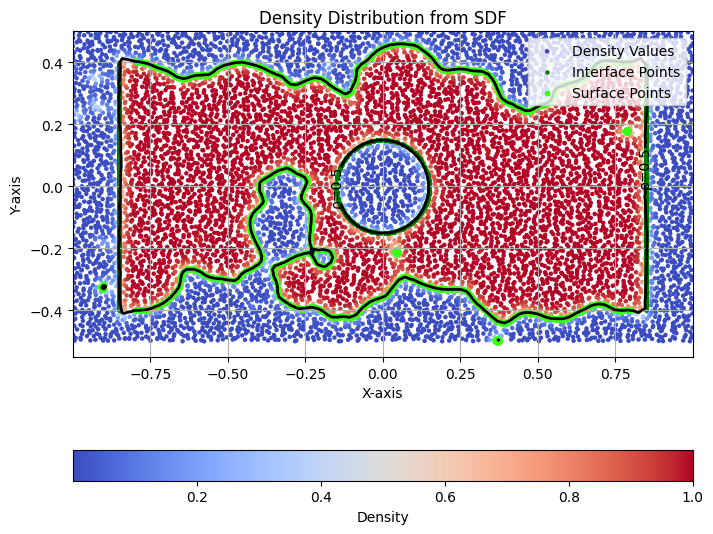

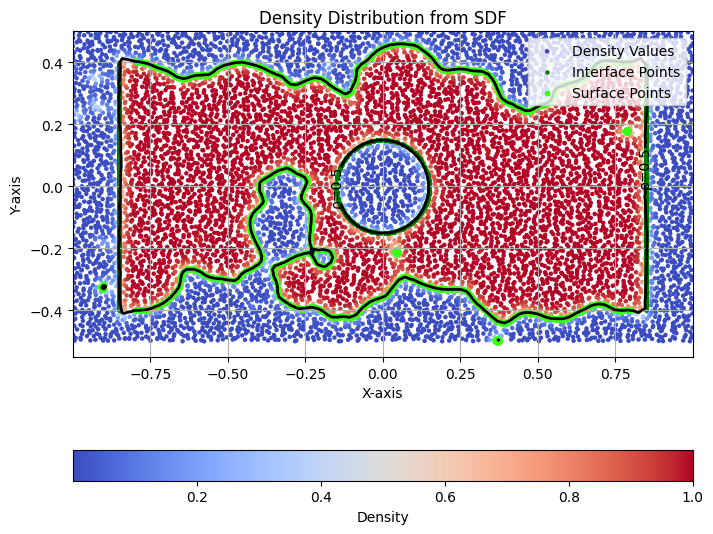

In [10]:
plot_GINN_geometry_with_surface_pts(BRIDGE,10000,GINN_model,surf_pts)

In [ ]:

def smoothness_loss(#self,
                    max_curv: float,
                    clip_min_value: float,
                    clip_max_value: float,
                    boundary_sampler,
                    start_epoch,
                    epoch) -> torch.Tensor:

        if epoch < start_epoch:
             print('Returning Zero Loss - Epoch below target')
             return torch.tensor(0.0, device=device, dtype=torch.float32, requires_grad=True)

        surface_points, weights = boundary_sampler.get_surface_pts()
        if surface_points.numel() == 0:
            print('Returning Zero Loss - No Surface Points Found')
            return torch.tensor(0.0, device=device, dtype=torch.float32, requires_grad=True)
        pts = surface_points.to(device)
        if pts.dim() != 2:
            raise ValueError(f"surface_points must be [B, D], got {pts.shape}")

        w = weights.to(device)
        if w.dim() == 2 and w.size(-1) == 1:
            w = w.squeeze(-1)
        if w.dim() != 1 or w.shape[0] != pts.shape[0]:
            raise ValueError(f"weights must be [B] or [B,1] matching points. Got {weights.shape}")

        B, D = pts.shape

        # First-order derivatives 
        pts = pts.clone().detach().requires_grad_(True)  
        sdf = GINN_model(pts).view(-1)            
        grad_outputs = torch.ones_like(sdf)

        df_dx = torch.autograd.grad(
            outputs=sdf,
            inputs=pts,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]  # [B, D]

        # Second-order derivatives
        H_rows = []
        for d in range(D):
            g_comp = df_dx[:, d]                        # [B]
            Hg = torch.autograd.grad(
                outputs=g_comp,
                inputs=pts,
                grad_outputs=torch.ones_like(g_comp),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]                                        # [B, D]
            H_rows.append(Hg.unsqueeze(1))              # [B, 1, D]
        H = torch.cat(H_rows, dim=1)                    # [B, D, D]

        #  Gaussian curvature 
        grad_sq = (df_dx.square()).sum(dim=1)           # [B]
        F4 = torch.clamp(grad_sq.square(), min=1.0e-15)

        top = torch.cat([H, df_dx.unsqueeze(2)], dim=2)                     # [B, D, D+1]
        bottom = torch.cat([df_dx.unsqueeze(1), torch.zeros(B, 1, 1, device=device, dtype=H.dtype)], dim=2)
        aug = torch.cat([top, bottom], dim=1)                                # [B, D+1, D+1]

        det_aug = torch.det(aug)                                             # [B]
        gauss_curvatures = (-1.0) / F4 * det_aug                             # [B]

        #  Mean curvature 
        FHFT = torch.einsum('bi,bij,bj->b', df_dx, H, df_dx)                 # [B]
        trH = torch.einsum('bii->b', H)                                      # [B]
        N = torch.clamp(grad_sq.sqrt(), min=1.0e-5)
        mean_curvatures = -(FHFT - (N.pow(2) * trH)) / (2.0 * N.pow(3))      # [B]

        # E-strain 
        E_strain = (2.0 * mean_curvatures).pow(2) - 2.0 * gauss_curvatures   # [B]
        E_strain = torch.clamp(E_strain, min=clip_min_value, max=clip_max_value)
        E_strain = E_strain * w
        total = E_strain.sum()                                               # scalar

        # loss = max(0, total - max_curv)
        zero = torch.tensor(0.0, device=device, dtype=torch.float32)
        loss = torch.maximum(zero, total - float(max_curv))

        return loss

In [12]:
smooth_loss = smoothness_loss(max_curv=0,
                              clip_max_value=1.0e+6,
                              clip_min_value=0,
                              boundary_sampler=boundary_sampler,
                              start_epoch = 500,
                              epoch= 1000)

# LOSS = 0 if we use MLP with Relu --> Not twice differentiable!
print(smooth_loss.item())

3321.37060546875
